In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import sys

IN_COLAB = 'google.colab' in sys.modules
REPO_DIR = '..' if IN_COLAB  else '..'

# Code

In [13]:
import os
import time
import itertools
import collections
from tqdm import tqdm

from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import sonnet as snt
import graph_nets
from graph_nets.graphs import GraphsTuple
import graph_attribution as gatt

# Ignore tf/graph_nets UserWarning:
# Converting sparse IndexedSlices to a dense Tensor of unknown shape
import warnings
warnings.simplefilter("ignore", UserWarning)

for mod in [tf, snt, gatt]:
    print(f'{mod.__name__:20s} = {mod.__version__}')

tensorflow           = 2.4.1
sonnet               = 2.0.0
graph_attribution    = 1.0.0b


## Graph Attribution specific imports

In [5]:
from graph_attribution import tasks
from graph_attribution import graphnet_models as gnn_models
from graph_attribution import graphnet_techniques as techniques
from graph_attribution import datasets
from graph_attribution import experiments
from graph_attribution import templates
from graph_attribution import graphs as graph_utils

datasets.DATA_DIR = os.path.join(REPO_DIR, 'data')
print(f'Reading data from: {datasets.DATA_DIR}')

Reading data from: ../data


# Load Experiment data, a task and attribution techniques

In [6]:
print(f'Available tasks: {[t.name for t in tasks.Task]}')
print(f'Available model types: {[m.name for m in gnn_models.BlockType]}')
print(f'Available ATT techniques: {list(techniques.get_techniques_dict(None,None).keys())}')

Available tasks: ['benzene', 'logic7', 'logic8', 'logic10', 'crippen', 'bashapes', 'treegrid', 'bacommunity']
Available model types: ['gcn', 'gat', 'mpnn', 'graphnet']
Available ATT techniques: ['Random', 'GradInput', 'SmoothGrad(GradInput)', 'GradCAM-last', 'GradCAM-all', 'CAM']


In [7]:
task_type = 'logic7'
block_type = 'gcn'

task_dir = datasets.get_task_dir(task_type)
exp, task, methods = experiments.get_experiment_setup(task_type, block_type)
task_act, task_loss = task.get_nn_activation_fn(), task.get_nn_loss_fn()
graph_utils.print_graphs_tuple(exp.x_train)
print(f'Experiment data fields:{list(exp.__dict__.keys())}')

Shapes of GraphsTuple's fields:
GraphsTuple(nodes=TensorShape([81088, 14]), edges=TensorShape([172570, 5]), receivers=TensorShape([172570]), senders=TensorShape([172570]), globals=TensorShape([3840, 1]), n_node=TensorShape([3840]), n_edge=TensorShape([3840]))
Experiment data fields:['x_train', 'x_test', 'y_train', 'y_test', 'att_test', 'x_aug', 'y_aug']


# Create a GNN model

## Define hparams of the experiment

In [8]:
hp = gatt.hparams.get_hparams({'block_type':block_type, 'task_type':task_type})
hp

batch_size: 256
block_type: gcn
edge_size: 20
epochs: 300
global_size: 100
learning_rate: 0.0003
n_layers: 3
node_size: 50
random_seed: 42
task_type: logic7

## Instantiate model

In [9]:
model = experiments.GNN(node_size = hp.node_size,
               edge_size = hp.edge_size,
               global_size = hp.global_size,
               y_output_size = task.n_outputs,
               block_type = gnn_models.BlockType(hp.block_type),
               activation = task_act,
               target_type = task.target_type,
               n_layers = hp.n_layers)
model(exp.x_train)
gnn_models.print_model(model)

GNN : gcn

| Variable                                  | Spec        | Trainable   | Device   |
|-------------------------------------------+-------------+-------------+----------|
| gcn/ReadoutGAP/linear/w                   | f32[20,100] | True        | CPU      |
| gcn/ReadoutGAP/linear/w                   | f32[50,100] | True        | CPU      |
| gcn/ReadoutGAP/linear/b                   | f32[100]    | True        | CPU      |
| gcn/ReadoutGAP/linear/b                   | f32[100]    | True        | CPU      |
| gcn/gcn_1/layer_norm/offset               | f32[50]     | True        | CPU      |
| gcn/gcn_1/layer_norm/scale                | f32[50]     | True        | CPU      |
| gcn/gcn_1/mlp/linear_0/w                  | f32[120,50] | True        | CPU      |
| gcn/gcn_1/mlp/linear_0/b                  | f32[50]     | True        | CPU      |
| gcn/gcn_1/mlp/linear_1/w                  | f32[50,50]  | True        | CPU      |
| gcn/gcn_1/mlp/linear_1/b                  | f32[50] 

# Train model on task



## Training loop

In [14]:
optimizer = snt.optimizers.Adam(hp.learning_rate)



opt_one_epoch = gatt.training.make_tf_opt_epoch_fn(exp.x_train, exp.y_train, hp.batch_size, model,
                                      optimizer, task_loss)

pbar = tqdm(range(hp.epochs))
losses = collections.defaultdict(list)
start_time = time.time()
for _ in pbar:
    train_loss = opt_one_epoch(exp.x_train, exp.y_train).numpy()
    losses['train'].append(train_loss)
    losses['test'].append(task_loss(exp.y_test, model(exp.x_test)).numpy())
    pbar.set_postfix({key: values[-1] for key, values in losses.items()})

losses = {key: np.array(values) for key, values in losses.items()}


  0%|          | 0/300 [00:10<?, ?it/s]

 18%|█▊        | 53/300 [00:26<01:57,  2.11it/s, train=0.0957, test=0.118]


 35%|███▌      | 105/300 [00:49<01:24,  2.31it/s, train=0.0679, test=0.0969]


 52%|█████▏    | 156/300 [01:12<01:02,  2.32it/s, train=0.0441, test=0.0909]


 69%|██████▉   | 207/300 [01:35<00:41,  2.27it/s, train=0.0333, test=0.0928]


 86%|████████▌ | 258/300 [01:58<00:19,  2.15it/s, train=0.0217, test=0.083]


100%|██████████| 300/300 [02:17<00:00,  2.18it/s, train=0.0179, test=0.0827]


## Plot losses

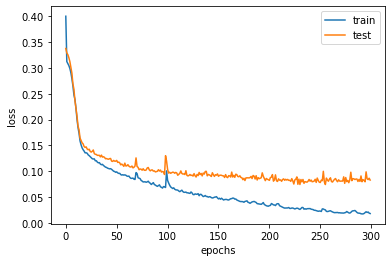

In [15]:
for key, values in losses.items():
  plt.plot(values, label=key)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

# Evaluate predictions and attributions

In [61]:
results = []
for method in tqdm(methods.values(), total=len(methods)):
  results.append(experiments.generate_result(model, method, task, exp.x_test, exp.y_test, exp.att_test))
pd.DataFrame(results)

,ATT AUROC,ATT F1,ATT ACC,AUROC,F1,ACC,Task,Technique,Model
0,0.431363,0.031471,0.019034,0.985848,0.854369,0.969136,(flouride & carbonyl),Random,gcn
1,0.596334,0.034140,0.068074,0.985848,0.854369,0.969136,(flouride & carbonyl),GradInput,gcn
2,0.691677,0.038024,0.119833,0.985848,0.854369,0.969136,(flouride & carbonyl),SmoothGrad(GradInput),gcn
3,0.602040,0.034197,0.067365,0.985848,0.854369,0.969136,(flouride & carbonyl),GradCAM-last,gcn
4,0.605443,0.035312,0.118345,0.985848,0.854369,0.969136,(flouride & carbonyl),GradCAM-all,gcn
5,0.791446,0.046374,0.953862,0.985848,0.854369,0.969136,(flouride & carbonyl),IG,gcn
6,0.767966,0.055071,0.907440,0.985848,0.854369,0.969136,(flouride & carbonyl),CAM,gcn


# Visualize attributions